/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Windows shape: (99, 1, 1000)
Running AE on 99 windows, r=512, D=1


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 12070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/pytorch/pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss 0.592530
Epoch 10, Loss 0.009482
Epoch 20, Loss 0.009287
Epoch 30, Loss 0.009375
Epoch 40, Loss 0.009338
Epoch 50, Loss 0.009303
Epoch 60, Loss 0.009357
Epoch 70, Loss 0.009174
Epoch 80, Loss 0.009225
Epoch 90, Loss 0.009146


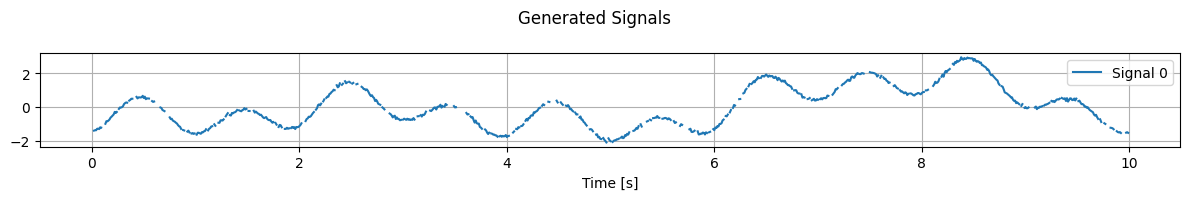

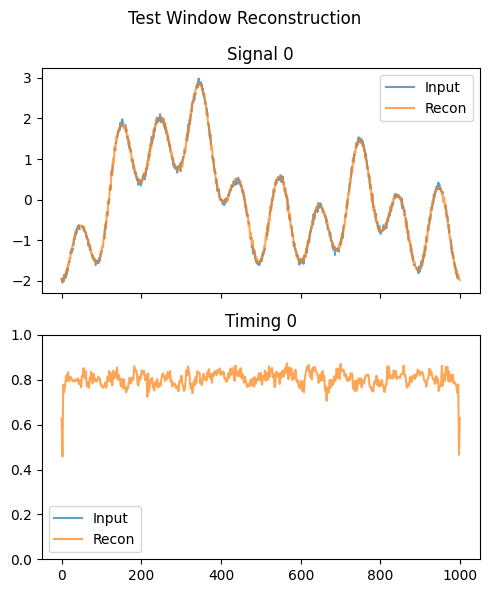

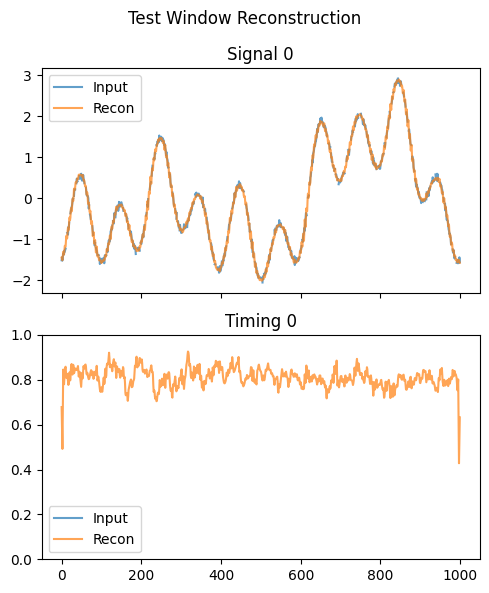

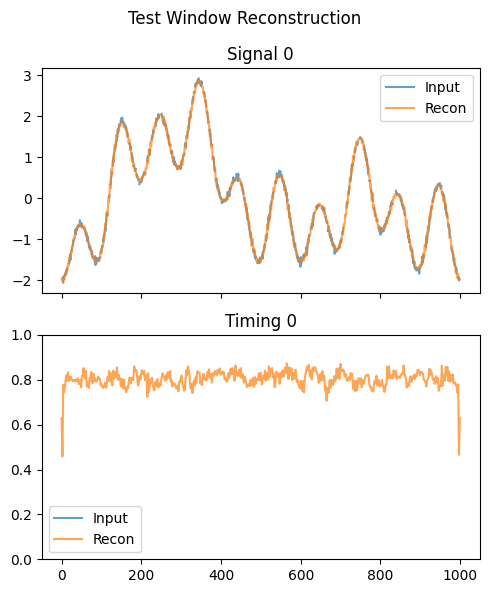

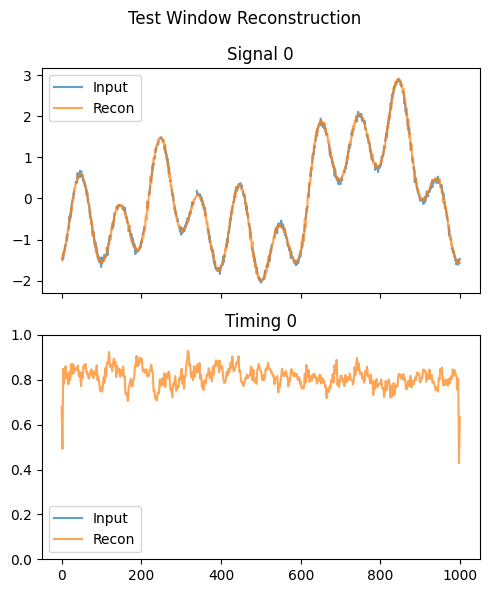

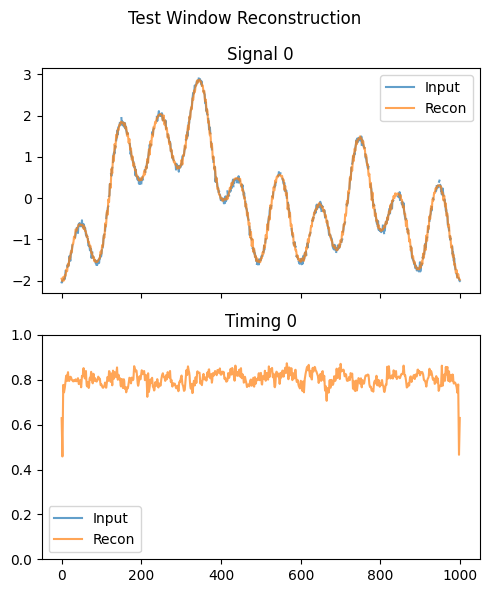

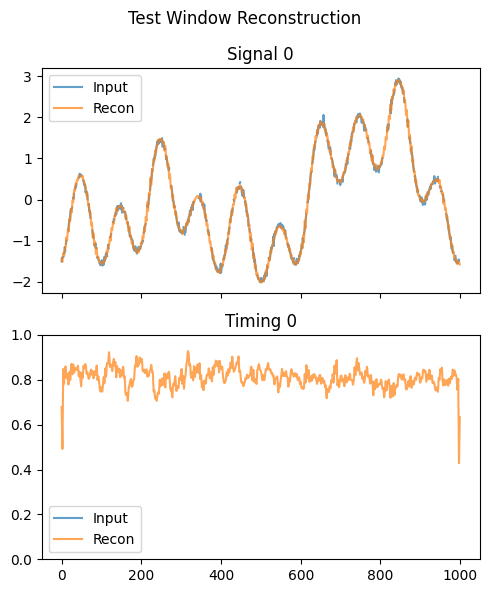

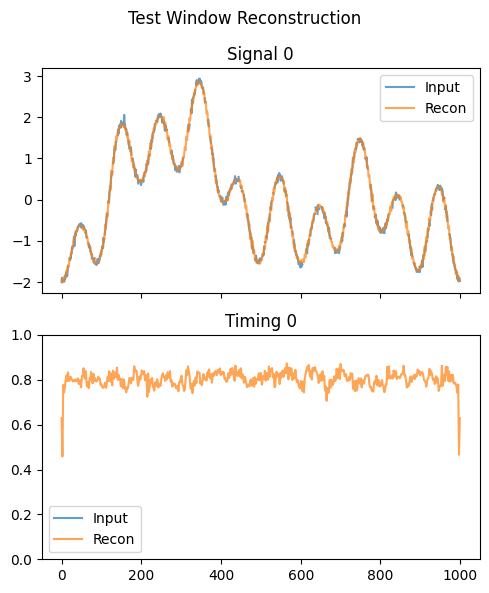

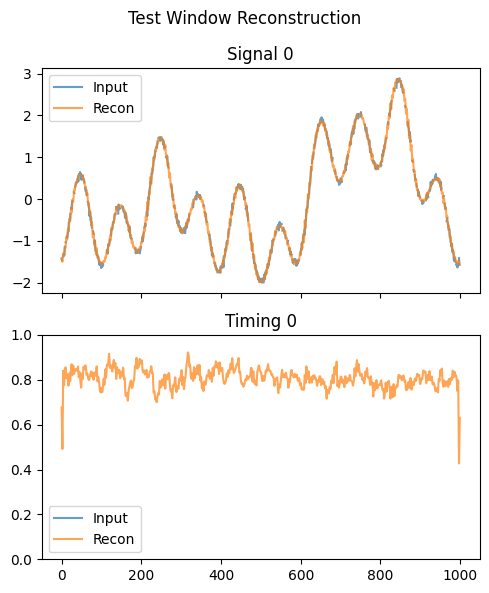

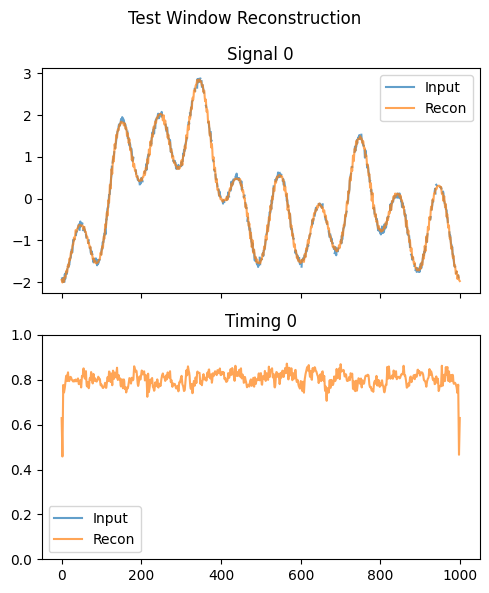

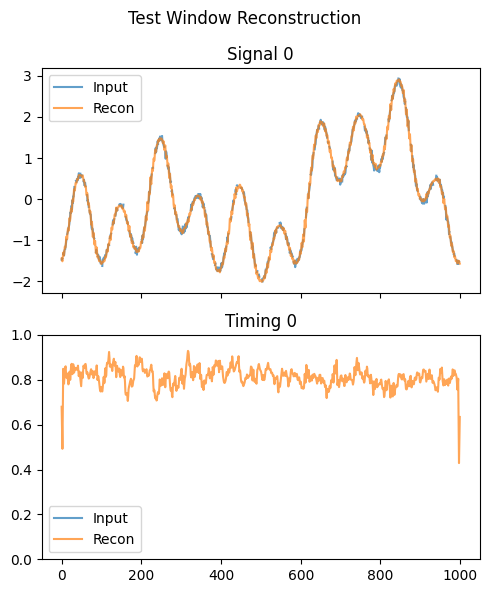

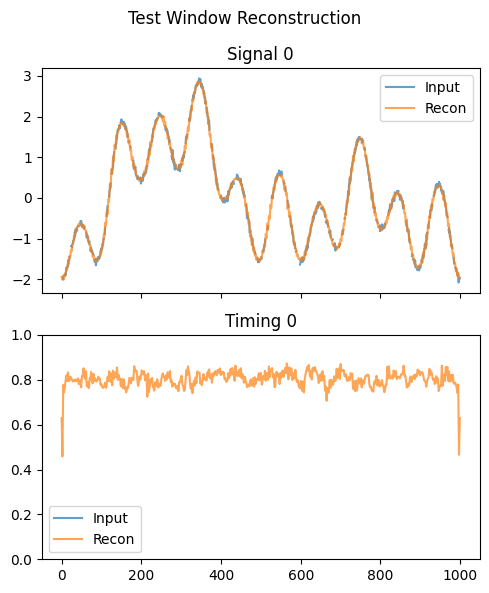

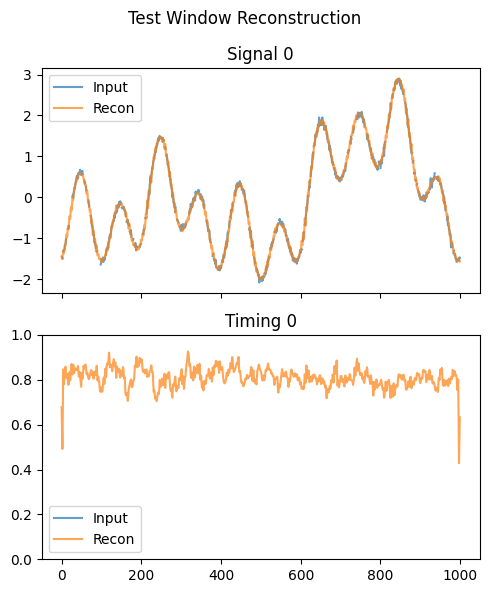

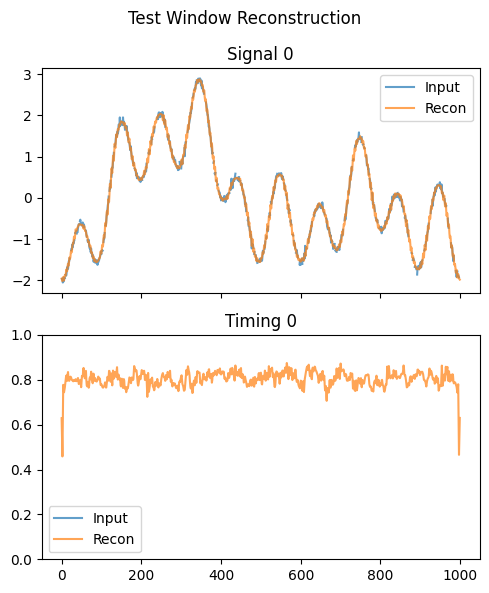

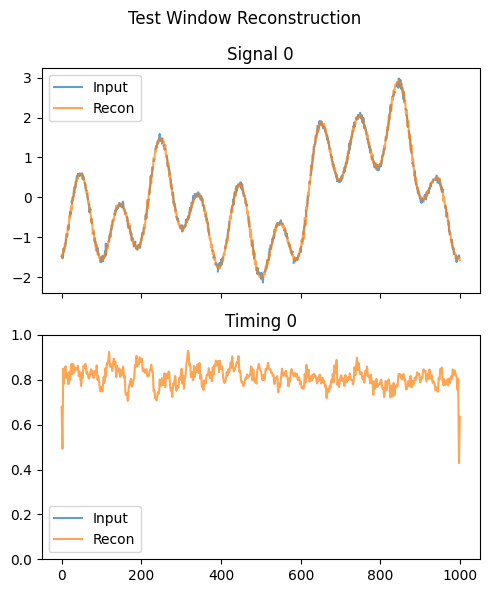

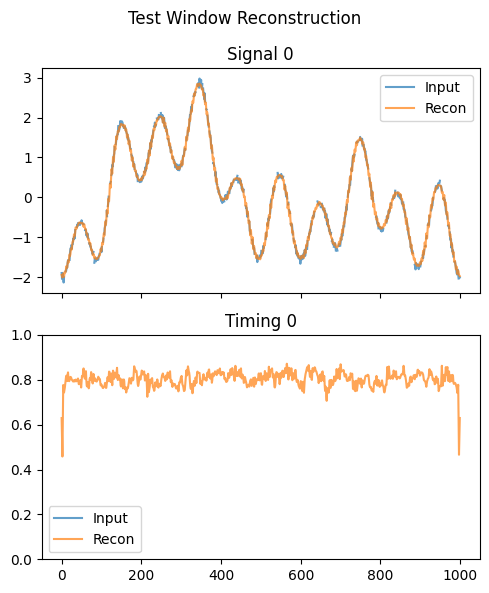

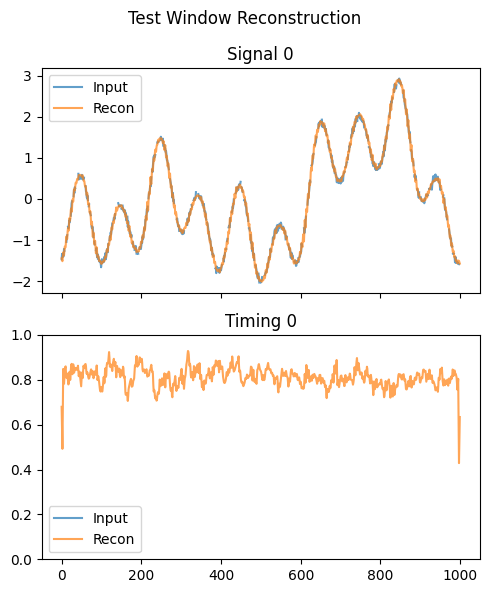

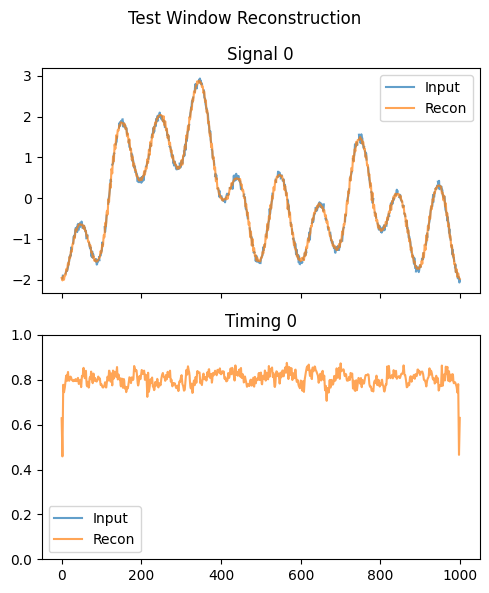

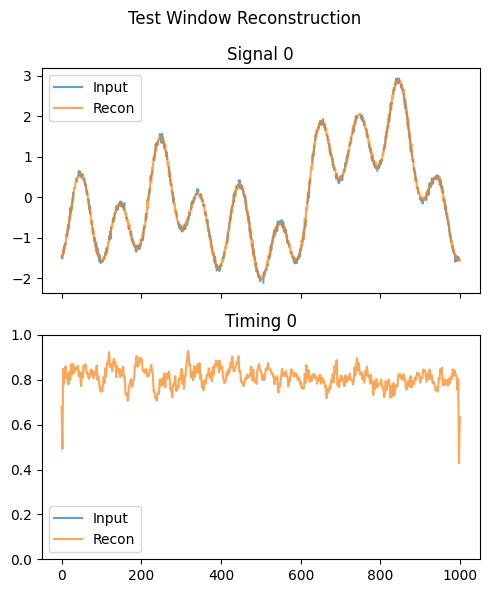

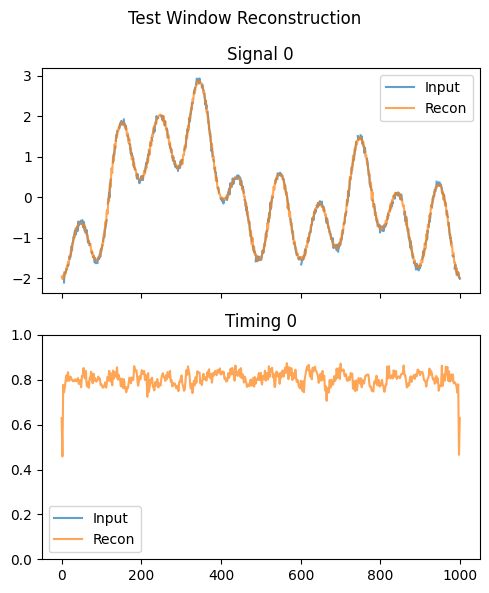

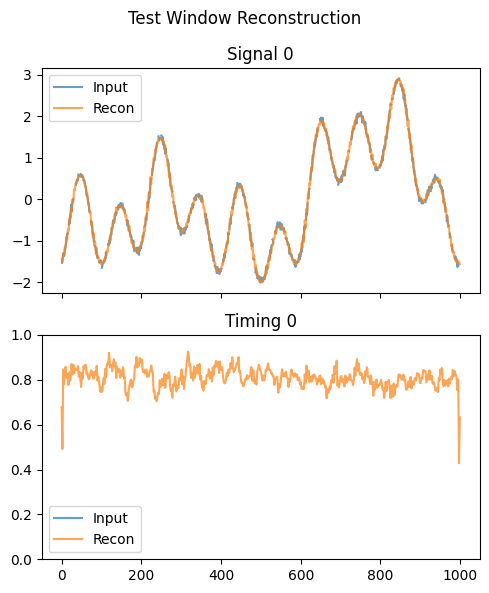

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))  # make sure we can import waveletae/

import torch
from waveletae.training.experiments import run_experiment_windows
from waveletae.training.signalgen import generate_multisine_signals
from waveletae.training.windowing import window_signals


# -------------------------
# 1. Generate test signal
# -------------------------
signals, masks, t = generate_multisine_signals(
    duration=500,      # seconds
    n=10,              # number of signals
    freqs=[0.1, 0.2, 0.5, 1],     # sine frequencies
    dt=0.01,          # base sampling rate
    sparsity=0.2,     # drop 20% randomly
    seed=42
)

# print("Signals shape:", signals.shape)  # (n, T)
# plot_signals(signals, t, masks, title="Raw Input Signals")

# -------------------------
# 2. Window into chunks
# -------------------------
win_signals, win_masks, win_times = window_signals(
    signals, masks, t,
    window_size=10.0,  # 10s windows
    step_size=5.0      # stride 5s
)

print("Windows shape:", win_signals.shape)  # (num_windows, n, T_window)

# -------------------------
# 3. Dataset + AE training
# -------------------------
model, dataset = run_experiment_windows(
    win_signals, win_masks, win_times,
    r=512,       # resampled resolution per window
    D=1,        # embedding dimension
    epochs=100,   # training epochs
    batch_size=4,
    timing_mode="gaussian",
)


In [ ]:
# -------------------------
# 4. Test reconstruction
# -------------------------
test_loader = DataLoader(dataset, batch_size=1)
signals_batch, masks_batch, times_batch = next(iter(test_loader))

with torch.no_grad():
    # Forward preprocess
    from waveletae.preprocessing.windowproc import forward_preprocess, backward_preprocess
    X = forward_preprocess(
        signals_batch.numpy(), masks_batch.numpy(),
        r=512, timing_mode="gaussian", use_dwt=True
    )
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(0)
    recon, e = model(X)

    # Backward preprocess
    recon_back = backward_preprocess(recon.squeeze(0).numpy(), use_dwt=True)

# -------------------------
# 5. Plot reconstructions
# -------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(times_batch.squeeze(0), signals_batch[0,0], label="Original Signal 0")
plt.plot(times_batch.squeeze(0), recon_back[0], "--", label="Reconstruction")
plt.legend()
plt.title("AE Reconstruction in Time Domain")
plt.show()

print("Embedding shape:", e.shape)